The synthetic non-rigid structure from motion dataset, has 100 frames and 2 shape bases.

Measurement matrix: matrix W
Original Structure: matrix S

The dimension of matrix W is 2F-by-P, where F is the total number of
frames and P is total number of points. The image observation for each
image is given in the pair of rows of matrix W. Similar format is used 
for matrix S, the structure at each time instant is a 3-by-P
matrix and is given in the 3-by-P block of matrix S. Hence the dimension
of S is 3F-by-P. 

To do: You need to reconstruct the 3D shape matrix S_hat from the measurement matrix W.

REMEMBER: provide your reconstructed shape in your submitted files.

In [4]:
import numpy as np

S = np.loadtxt('/home/daizj/Homeworks/gv/HW5/data/S_correct.txt', delimiter = ',')
W = np.loadtxt('/home/daizj/Homeworks/gv/HW5/data/W.txt', delimiter = ',')
print("s shape:",S.shape)
print("w shape:",W.shape)

F = W.shape[0] // 2
P = W.shape[1]
K = 2

W_ = W # the registered measurement matrix
U, s, Vt = np.linalg.svd(W_, full_matrices=False)
s_3k = np.diag(np.sqrt(s)[ :3*K]) # sqrt?
print("s_3k:", s_3k.shape)
M_ = U[:, :3*K] @ s_3k # 2F × 3K
B_ = s_3k @ Vt[:3*K, :] # 3K × P
print("M_:", M_.shape)
print("B_:", B_.shape)

s shape: (300, 60)
w shape: (200, 60)
s_3k: (6, 6)
M_: (200, 6)
B_: (6, 60)


In [5]:
import sympy as sp
from scipy.linalg import orthogonal_procrustes
# obtain constraints
# Qk is symmetric 6x6 21 unknowns

def get_coeffs(qk_list, eq, b):
    coeffs = [eq.coeff(qk) for qk in qk_list]
    coeffs.append(b)
    return coeffs
    
G = []
C = []
for k in range(K):
    Qk = sp.MatrixSymbol('Qk', 3*K, 3*K)
    Qk = sp.Matrix(3*K, 3*K, lambda i,j: sp.symbols(f'q_{i+1}{j+1}') if i <= j else sp.symbols(f'q_{j+1}{i+1}'))
    qk_list = [Qk[i, j] for i in range(Qk.rows) for j in range(i, Qk.cols)]
    # rotation
    rot_constraints = []
    for i in range(F):
        M2i_1 = M_[i * 2,:].reshape(1,-1)
        M2i = M_[(i * 2 + 1), :].reshape(1,-1)
        # Constraint 10
        eq10 = M2i_1 @ Qk @ M2i_1.T - M2i @ Qk @ M2i.T
        eq10_coeffs = get_coeffs(qk_list, eq10[0,0], 0)
        rot_constraints.append(eq10_coeffs)
        # Constraint 11
        eq11 = M2i_1 @ Qk @ M2i.T
        eq11_coeffs = get_coeffs(qk_list, eq11[0,0], 0)
        rot_constraints.append(eq10_coeffs)
    print("rotation_constraints:",len(rot_constraints))
    
    # base
    basis_constraints = []
    for i in range(K):
        for j in range(F):
            M2i_1 = M_[i * 2,:].reshape(1,-1)
            M2i = M_[(i * 2 + 1), :].reshape(1,-1)
            M2j_1 = M_[j * 2,:].reshape(1,-1)
            M2j = M_[(j * 2 + 1), :].reshape(1,-1)
            eq25 = M2i_1 @ Qk @ M2j_1.T
            eq26 = M2i @ Qk @ M2j.T
            eq27 = M2i_1 @ Qk @ M2j.T
            eq28 = M2i @ Qk @ M2j_1.T
            if i != j and i == k:
                continue
            if i == j and i == k:
                eq25_coeffs = get_coeffs(qk_list, eq25[0,0], 1)
                eq26_coeffs = get_coeffs(qk_list, eq26[0,0], 1)
                eq27_coeffs = get_coeffs(qk_list, eq27[0,0], 0)
                eq28_coeffs = get_coeffs(qk_list, eq28[0,0], 0)
            if i != k:
                eq25_coeffs = get_coeffs(qk_list, eq25[0,0], 0)
                eq26_coeffs = get_coeffs(qk_list, eq26[0,0], 0)
                eq27_coeffs = get_coeffs(qk_list, eq27[0,0], 0)
                eq28_coeffs = get_coeffs(qk_list, eq28[0,0], 0)
            basis_constraints.append(eq25_coeffs)
            basis_constraints.append(eq26_coeffs)
            basis_constraints.append(eq27_coeffs)
            basis_constraints.append(eq28_coeffs)
    print("basis_constraints:",len(basis_constraints))

    rc = np.array(rot_constraints)
    bc = np.array(basis_constraints)
    eq_matrix = np.vstack((rot_constraints, basis_constraints)).astype(np.float64)
    # least square method
    solution = np.linalg.lstsq(eq_matrix[:, :-1], eq_matrix[:, -1], rcond=None)[0]
    Qk_ = np.zeros((3*K, 3*K))
    Qk_[np.triu_indices(3*K)] = solution.tolist()
    Qk_ = Qk_ + Qk_.T - np.diag(np.diag(Qk_))
    U,s,Vt = np.linalg.svd(Qk_)
    #gk_phi = U[:,:3] @ np.diag(np.sqrt(s))[:3,:3] @ Vt[:3,:3]
    gk_phi = U[:,:3] @ np.diag(np.sqrt(s[:3]))

    M = M_ @ gk_phi
    M_norm = np.linalg.norm(M, axis=1).reshape(-1, 1)
    if k == 0:
        gk = gk_phi
    else:
        M = M / M_norm
        M_rot = M_ @ G[0] / C[0]
        phi, _ = orthogonal_procrustes(M, M_rot)
        gk = gk_phi @ phi
    G.append(gk)
    C.append(M_norm) 
G = np.hstack(G) 
C = np.hstack(C)
print(G)
M = M_ @ G
B = np.linalg.inv(G) @ B_   

rotation_constraints: 200
basis_constraints: 404
rotation_constraints: 200
basis_constraints: 404
[[-0.42229654 -0.59240335 -0.99895301  0.68323618  2.01190258  2.14084966]
 [ 1.24333012 -0.15853583 -0.00748899 -3.389539    0.47874314  0.80567014]
 [ 0.12249188  1.00073335 -1.02963513 -0.30059968 -2.85624249  2.14631865]
 [ 1.42089386  3.21359249 -0.11388304  0.93677014  2.93000988 -0.17779189]
 [ 1.08235307 -0.62862484 -3.04838559  0.17769973 -0.3918496  -2.95581664]
 [ 3.40385594 -1.19318182  0.93271399  3.18845511 -0.9380306   1.42848923]]


In [27]:
S_ = np.zeros((3*F,P))
for i in range(F):
    for k in range(K):
        S_[3*i:3*i+3, :] += C[2*i, k] * B[3*k:3*k+3, :]

# align
Spoint = np.hstack([S[3*i:3*i+3, :] for i in range(F)])
S_point = np.hstack([S_[3*i:3*i+3, :] for i in range(F)])
R, _ = orthogonal_procrustes(S_point.T, Spoint.T)
# print(R)

error = []
for i in range(F):
    S_[3*i:3*i+3, :] = (S_[3*i:3*i+3, :].T @ R).T
    error.append(np.linalg.norm((S_ - S)[3*i:3*i+3, :]) / P)
variance = np.var(error)
print("The mean error:",sum(error) / len(error))
print("The stand deviation:",variance)

The mean error: 0.014074723559774682
The stand deviation: 0.00020545619171280497


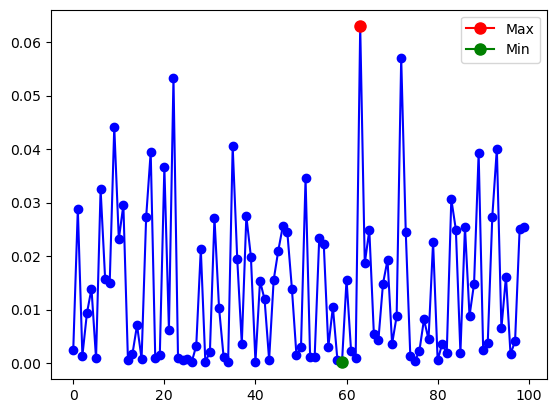

max error id: 63
min error id: 59


In [16]:
import matplotlib.pyplot as plt

idx = [i for i in range(len(error))]
fig, ax = plt.subplots()
ax.plot(idx, error, marker='o', linestyle='-', color='blue')
max_index = error.index(max(error))
min_index = error.index(min(error))
ax.plot(idx[max_index], error[max_index], marker='o', markersize=8, color='red', label='Max')
ax.plot(idx[min_index], error[min_index], marker='o', markersize=8, color='green', label='Min')
ax.legend()
plt.show()
print("max error id:",max_index)
print("min error id:",min_index)

In [23]:
def visualize_3d(p,q):
    # Plotting p and q in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(p[:, 0], p[:, 1], p[:, 2], c="red", label="p")
    ax.scatter(q[:, 0], q[:, 1], q[:, 2], c="blue", label="q")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Scatter plot of p and q in 3D")
    ax.legend()
    plt.show()

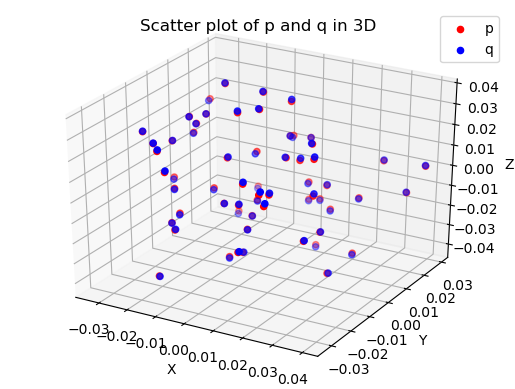

In [24]:
Smin = S[3*min_index:3*min_index+3, :].T
S_min = S_[3*min_index:3*min_index+3, :].T
visualize_3d(Smin,S_min)

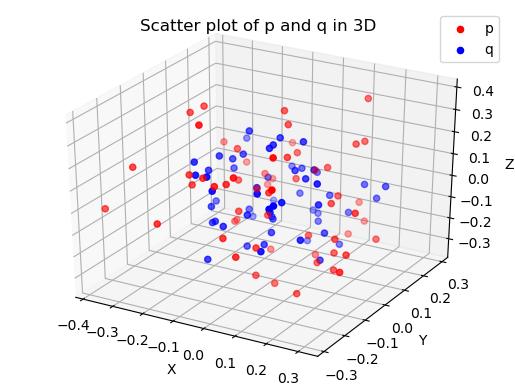

In [25]:
Smax = S[3*max_index:3*max_index+3, :].T
S_max = S_[3*max_index:3*max_index+3, :].T
visualize_3d(Smax,S_max)